___Описание проекта:___  
___Несмотря на огромные вложения в рекламу, последние несколько месяцев компания развлекательного приложения Procrastinate Pro+ терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.___   

___Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:___  
___лог сервера с данными об их посещениях,___ 
___выгрузка их покупок за этот период,___  
___рекламные расходы.___  
___Нам предстоит изучить:___  
___откуда приходят пользователи и какими устройствами они пользуются,___  
___сколько стоит привлечение пользователей из различных рекламных каналов;___  
___сколько денег приносит каждый клиент,___  
___когда расходы на привлечение клиента окупаются,___  
___какие факторы мешают привлечению клиентов.___  

Загрузите данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/visits_info_short.csv);
- заказы: `/datasets/orders_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/orders_info_short.csv);
- расходы: `/datasets/costs_info_short.csv`. [Скачать датасет](https://code.s3.yandex.net/datasets/costs_info_short.csv).

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

In [80]:
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

visits=pd.read_csv('/datasets/visits_info_short.csv')
orders=pd.read_csv('/datasets/orders_info_short.csv')
costs=pd.read_csv('/datasets/costs_info_short.csv')

visits.columns=visits.columns.str.lower()
visits=visits.rename(columns={'session start':'session_start','session end':'session_end','user id':'user_id'})


visits['session_start']=pd.to_datetime(visits['session_start'])
visits['session_end']=pd.to_datetime(visits['session_end'])
visits.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [81]:
orders.columns=orders.columns.str.lower()
orders=orders.rename(columns={'user id':'user_id','event dt':'event_dt'})
orders['event_dt']=pd.to_datetime(orders['event_dt'])
orders.info()
orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


In [82]:
costs.columns=costs.columns.str.lower()
costs['dt']=pd.to_datetime(costs['dt']).dt.date
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [83]:
visits.duplicated().sum()

0

In [84]:
orders.duplicated().sum()

0

In [85]:
costs.duplicated().sum()

0

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [86]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [87]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [88]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [89]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [90]:
# функция для сглаживания данных
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [91]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [92]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [93]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(15, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.

___Применим функцию get_profles для загрузки профилей пользователей___

In [94]:
events=None # исключим парамер events, т.к.  у нас его нет 
profiles = get_profiles(visits, orders, events, costs)
profiles


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [95]:
min_date=profiles['first_ts'].min()
min_date

Timestamp('2019-05-01 00:00:41')

In [96]:
max_date=profiles['first_ts'].max()
max_date

Timestamp('2019-10-27 23:59:04')

___Минимальная дата привлеения -1 мая 2019, максимальная -27 октября 2019___

In [97]:
profiles1=profiles.groupby('region').agg({'user_id':'nunique'}).rename(columns={'user_id':'total'})
profiles1
profiles2=profiles.query('payer==True').groupby('region').agg({'user_id':'nunique'}).rename(columns={'user_id':'payers'})
profiles3=profiles1.merge(profiles2,on='region')
profiles3['part%']=round(profiles3['payers']/profiles3['total']*100,2)
profiles3.sort_values(by='part%',ascending=False)

,total,payers,part%
region,,,
United States,100002,6902,6.90
Germany,14981,616,4.11
UK,17575,700,3.98
France,17450,663,3.80


___Больше всего пользователей приходятся на США -100 тыс , доля платящих пользователей так же самая большая в США -почти 7%, Меньше всего пользователей приходится на Германию -около 15 тыс , а самая меньшая доля платящх пользователей-на Францию -3,8%___

In [98]:
profiles4=profiles.groupby('device').agg({'user_id':'nunique'}).rename(columns={'user_id':'total'})
profiles4
profiles5=profiles.query('payer==True').groupby('device').agg({'user_id':'nunique'}).rename(columns={'user_id':'payers'})
profiles6=profiles5.merge(profiles4,on='device')
profiles6['part%']=round(profiles6['payers']/profiles6['total']*100,2)
profiles6.sort_values(by='part%',ascending=False)

,payers,total,part%
device,,,
Mac,1912,30042,6.36
iPhone,3382,54479,6.21
Android,2050,35032,5.85
PC,1537,30455,5.05


___Больше всего пользователей приложения исползуют iPhone-54 тыс, меньше всего -Mac и PC-около 30 тыс. Платящих пользователей приложения больше всего приходится на пользователей Mac и iPhone (6,36% и 6,21%), меньше всего -на пользователей PC (5,05%)___

In [99]:
profiles7=profiles.groupby('channel').agg({'user_id':'nunique'}).rename(columns={'user_id':'total'})
profiles8=profiles.query('payer==True').groupby('channel').agg({'user_id':'nunique'}).rename(columns={'user_id':'payers'})
profiles9=profiles8.merge(profiles7,on='channel')
profiles9['part%']=round(profiles9['payers']/profiles9['total']*100,2)
profiles9.sort_values(by='part%',ascending=False)

,payers,total,part%
channel,,,
FaceBoom,3557,29144,12.20
AdNonSense,440,3880,11.34
lambdaMediaAds,225,2149,10.47
TipTop,1878,19561,9.60
RocketSuperAds,352,4448,7.91
WahooNetBanner,453,8553,5.30
YRabbit,165,4312,3.83
MediaTornado,156,4364,3.57
LeapBob,262,8553,3.06


___Если не считать органических пользователей (таким путем в приложение пришли наибольшее кол-во пользователей 56тыс),наибольшее количество пользователей пришло через каналы привлечения FaceBoom и TipTop(29 тыс и 19 тыс )___  
___Однако, доля платящих у органических пользователей наименьшая-2,06%. Наибольшая доля платящих пользователей пришли через каналы привлечения FaceBoom,AdNonSense и lambdaMediaAds(12,2% , 11,34% и 10,47%)___

.### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.

In [100]:

costs['costs'].sum()

105497.30000000002

___Всего сумма расходов на маркеинг составила 105497,3 долларов___

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


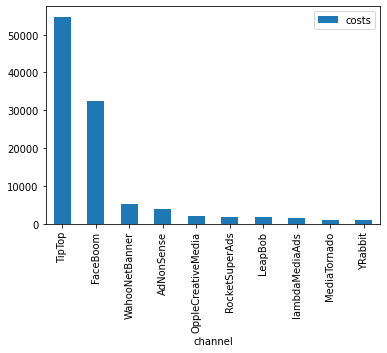

In [101]:
costs_channel=costs.groupby('channel').agg({'costs':'sum'})
costs_channel.sort_values(by='costs',ascending=False).plot(kind='bar')
costs_channel.sort_values(by='costs',ascending=False)


___Больше всего средств было потрачено на источники привлечения TipTop и FaceBoom (54 тыс и 32 тыс долларов), меньше всего-на источники MediaTornado и YRabbit(954 и 944 доллара)___

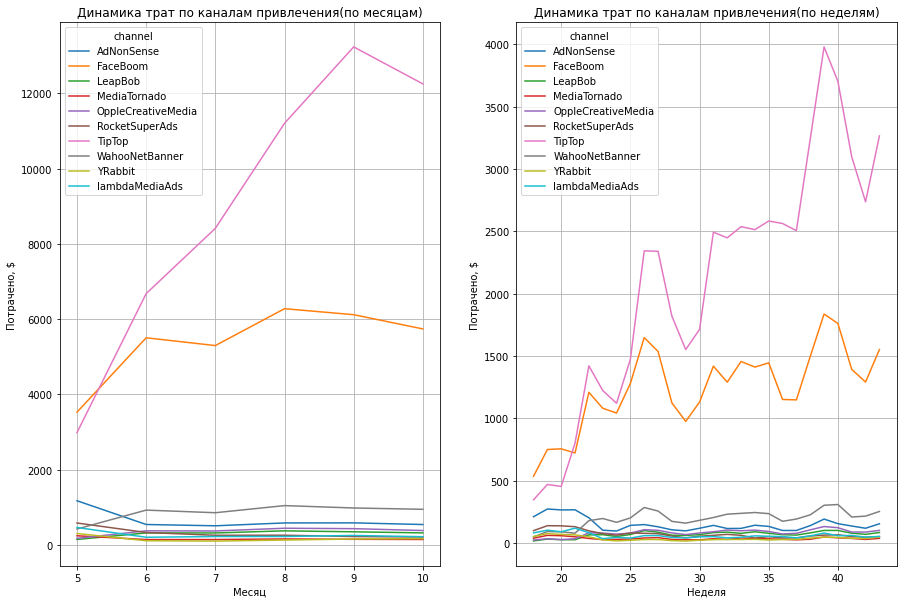

In [102]:
costs['dt']=pd.to_datetime(costs['dt'])
costs['month']=costs['dt'].dt.month
#costs['month'] = costs['dt'].astype('datetime64[M]')
costs['week']=costs['dt'].dt.isocalendar().week
costs_month=costs.pivot_table(index='month',columns='channel',values='costs',aggfunc='sum')
costs_week=costs.pivot_table(index='week',columns='channel',values='costs',aggfunc='sum')

plt.figure(figsize=(15,10))
ax1=plt.subplot(1,2,1)
costs_month.plot(grid=True,ax=ax1)
plt.ylabel('Потрачено, $')
plt.xlabel('Месяц')
plt.title('Динамика трат по каналам привлечения(по месяцам)')

ax2=plt.subplot(1,2,2)
costs_week.plot(grid=True,ax=ax2)
plt.ylabel('Потрачено, $')
plt.xlabel('Неделя')
plt.title('Динамика трат по каналам привлечения(по неделям)')

plt.show()

___По графикам динамики трат по каналам привлечения,построенным по месяцам и неделям , видно что больше всего было потрачено средств на TipTop и FaceBoom, причем траты на TipTop с каждым месяцем заметно росли ,до сентября , затем начали снижаться.Рфсходы на FaceBoom тоже росли , но не так сильно ,как на TipTop___  
___Траты на остальные каналы привлечения ,были стабильно невысокими, можно отметить только канал привлечения AdNonSense: в мае траты на него были чуть больше остальных(не считая лидеров) ,а к июню снизились до остальных и больше не поднимались. И канал привлечения WahooNetBanner -у него напротив , в мае были траты на равне со всеми (не считая лидеров) , а с июня стали стабилбно выше(но и не росли дальше)___

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


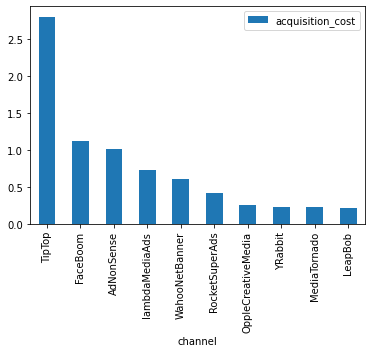

In [103]:
profiles_channel=profiles.query('channel!="organic"').groupby('channel').agg({'acquisition_cost':'mean'})
profiles_channel.sort_values(by='acquisition_cost',ascending=False).plot(kind='bar')
profiles_channel.sort_values(by='acquisition_cost',ascending=False)

___Самая высокая стоимость привлечения 1 пользователя (CAC) у канала привлечения TipTop (2,8 дол). Так же высокая стоимость привлечения у FaceBoom и AdNonSense (1,11дол и 1 дол)___  
___Самая низкая CAC  у каналов привлечения YRabbit,MediaTornado и LeapBop (около 21 цента)___

In [104]:
acquisition_mean=profiles.query('channel!="organic"')['acquisition_cost'].mean()
acquisition_mean

1.1274813239427588

___Средняя стоимость привлечения 1 клиента по всем каналам -1,12 долларов___

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [105]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 
profiles=profiles.query('channel!="organic"') # исключили из анализа органических пользователей

In [106]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

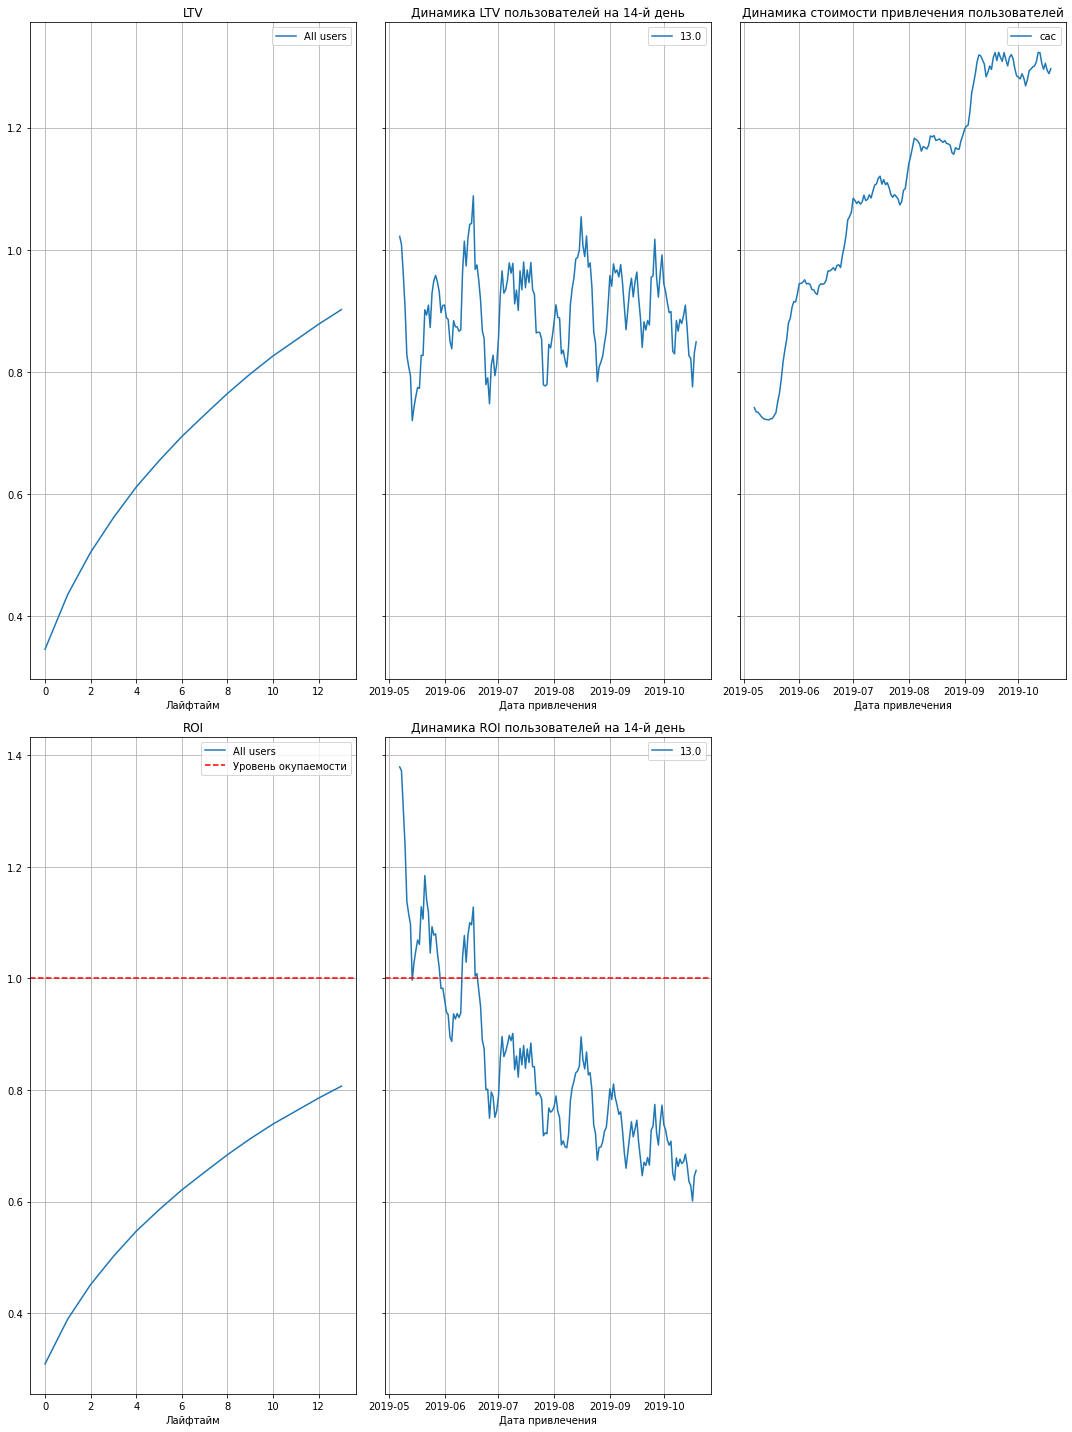

In [107]:
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

___По графикам можно сделать выводы:___
___-Реклама не окупается . За 2 недели ROI немного не дотягивает до 1 -отметки окупаемости___  
___-Динамика стоимости привлечения пользователей (CAC)постоянно и сильно растет-скорее всего это и является причиной низкого ROI___  
___-В начале анализируемого периода(в мае) и до середины июня ROI был досточно высоким -т.е. реклама окупалась,затем в июле он опять немного поднялся , но начиная с конца июля ROI стабильно ниже единицы___  
___-LTV достаточно стабилен (т.е качество привлеченных пользователей нельзя назвать плохим)___  

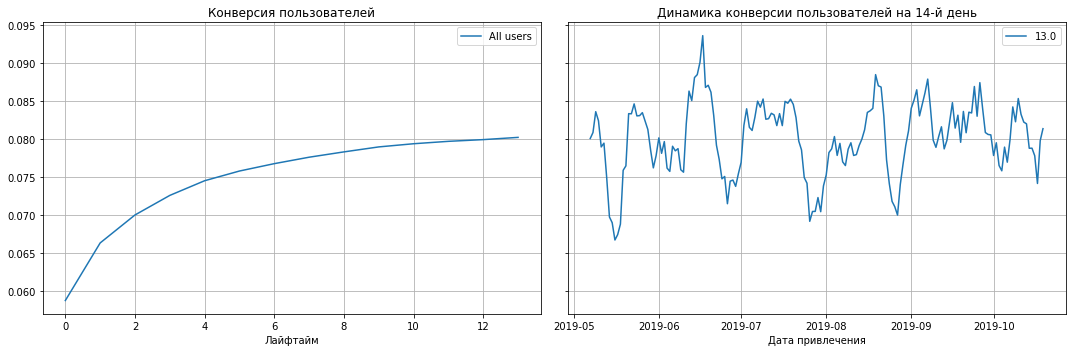

In [108]:
dimensions=[]
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

___Конверсия пользователей растет не так хорошо,как хотелось бы. До 6 лайфтайма она еще неплохая, но затем рост практически стоит на месте.Т.е. переход пользователей в платящих происходит в основном в первую неделю после привлечения___  

__Посмотрим так же на конверсию в разрезе устройств,стран и каналов привлечения___  

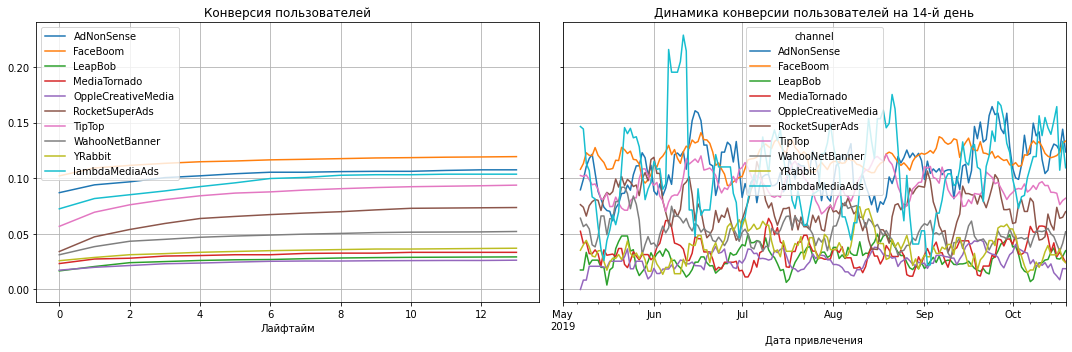

In [109]:
dimensions=['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

___Лучше всего конвертируются польователи ,пришедшие в приложение через каналы привлечения FaceBoom,AdNonSense,LambdaMediaAds и TipTop, хуже всего-пользователи ,пришедшие через  OppleCreativeMedia,LeapBop,MediaTornado и YRabbit___

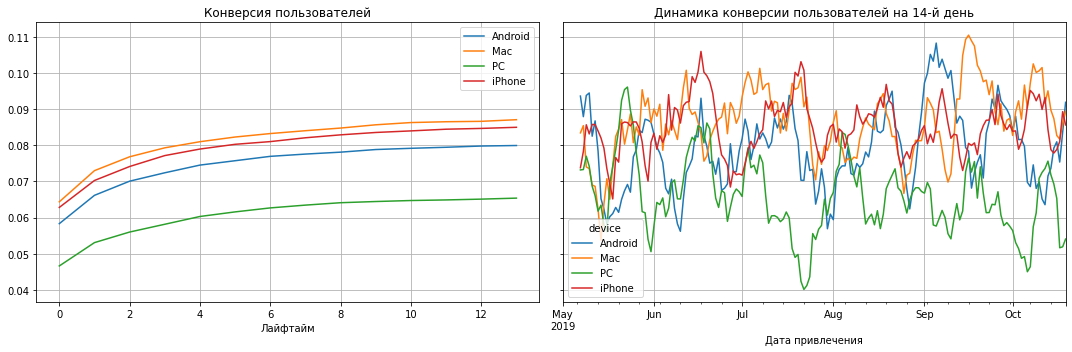

In [110]:
dimensions=['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

___Лучше всего конвертируюются пользователи Mac и IPhone,хуже-пользователи PC___  

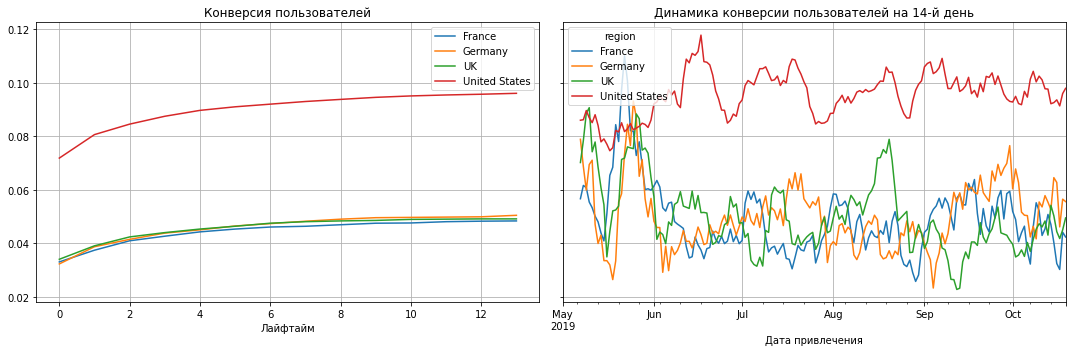

In [111]:
dimensions=['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

___Лучше всех конвертируются пользователи из США(почти на 40% лучше остальных стран), остальные страны конвертируются примерно одинаково___

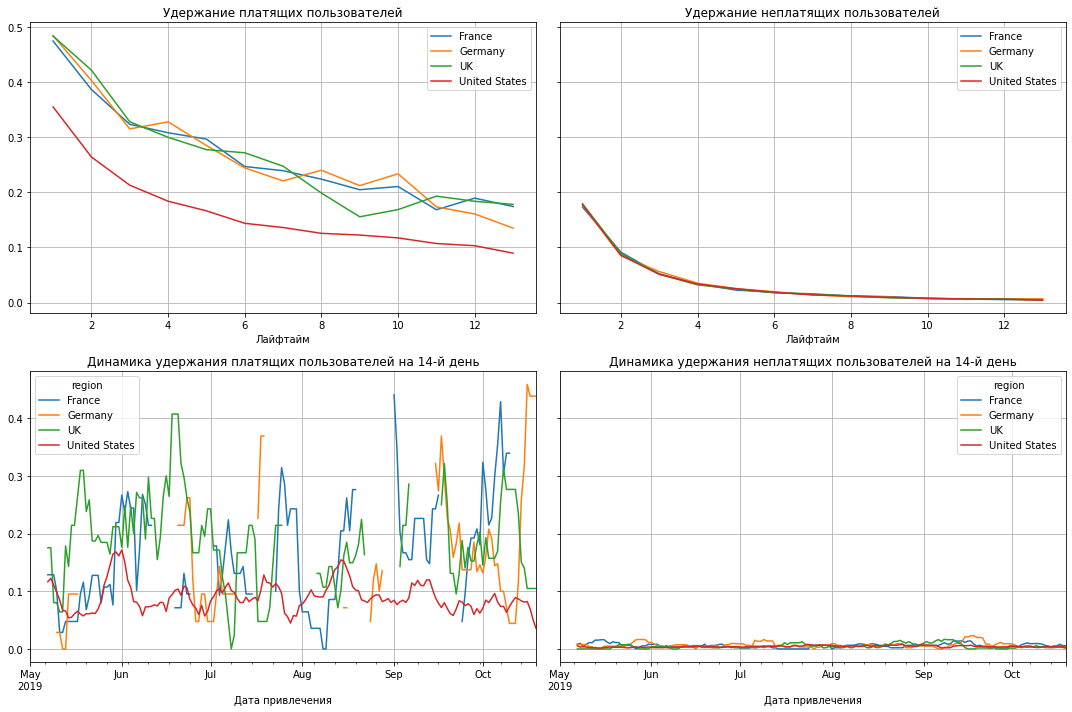

In [112]:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

___График удержания выглядит неплохо. Каких-то отклонений не видно___

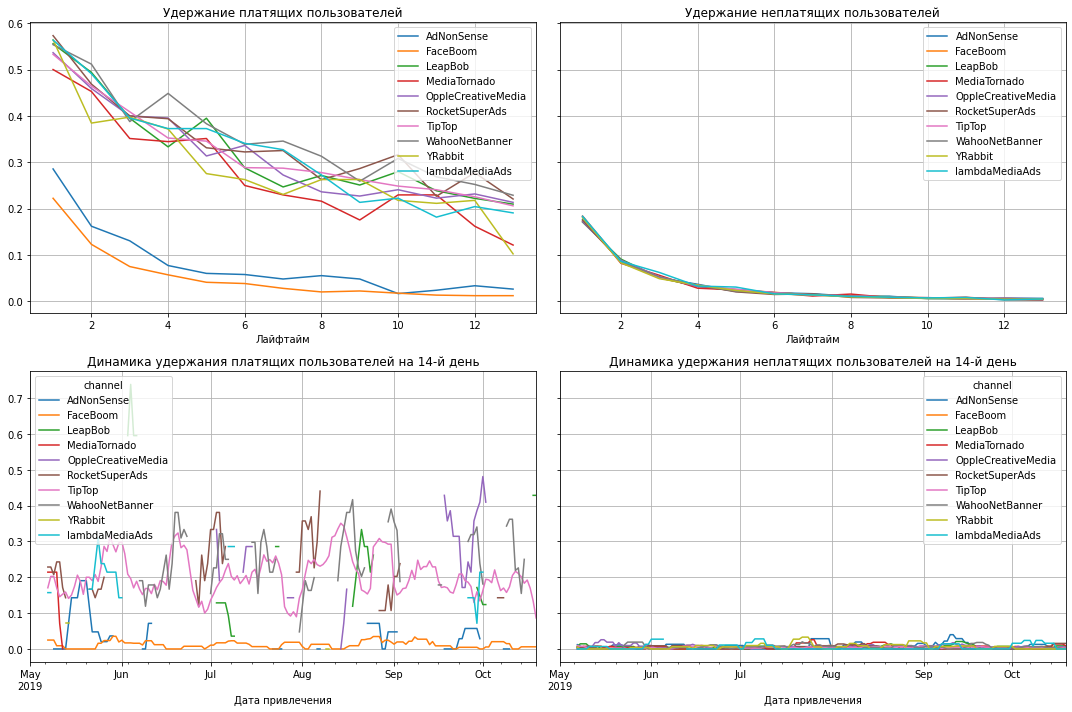

In [113]:
dimensions=['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

___Хуже всего удерживаются пользователи , пришедшие через канал FaceBoom и AdNonSense.Пользователи ,пришедшие через остальные каналы привлечения удерживаются примерно одинаково___

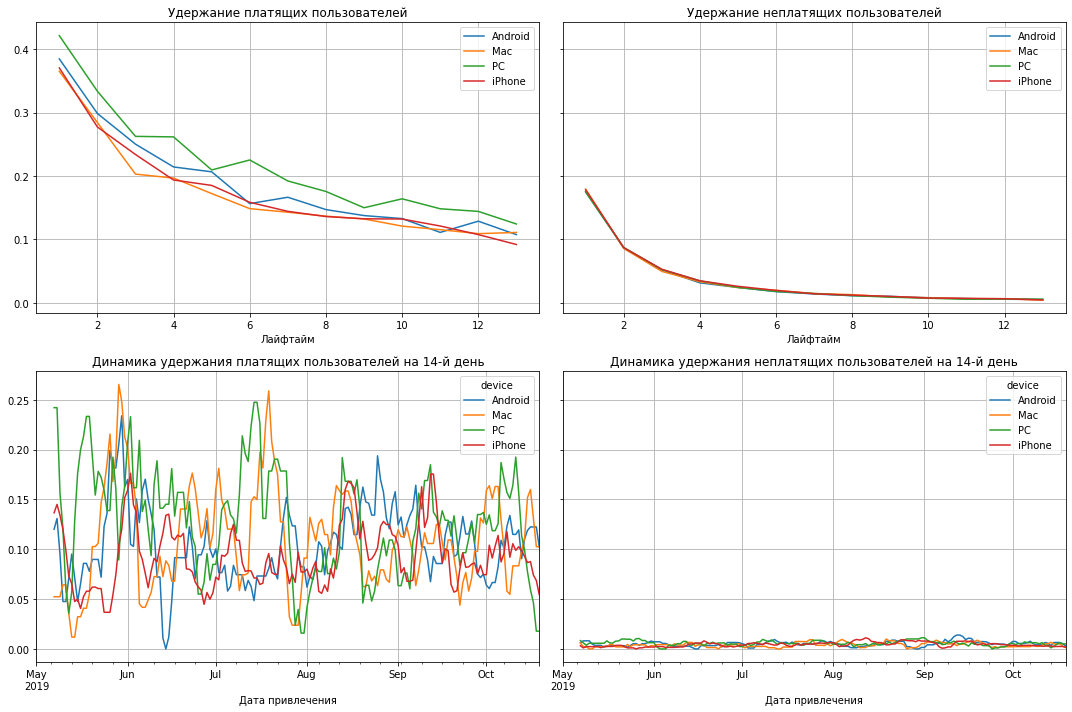

In [114]:
dimensions=['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

___Лучше всего удерживаются пользователи PC,немного хуже остальных -пользователи iPhone и Mac___

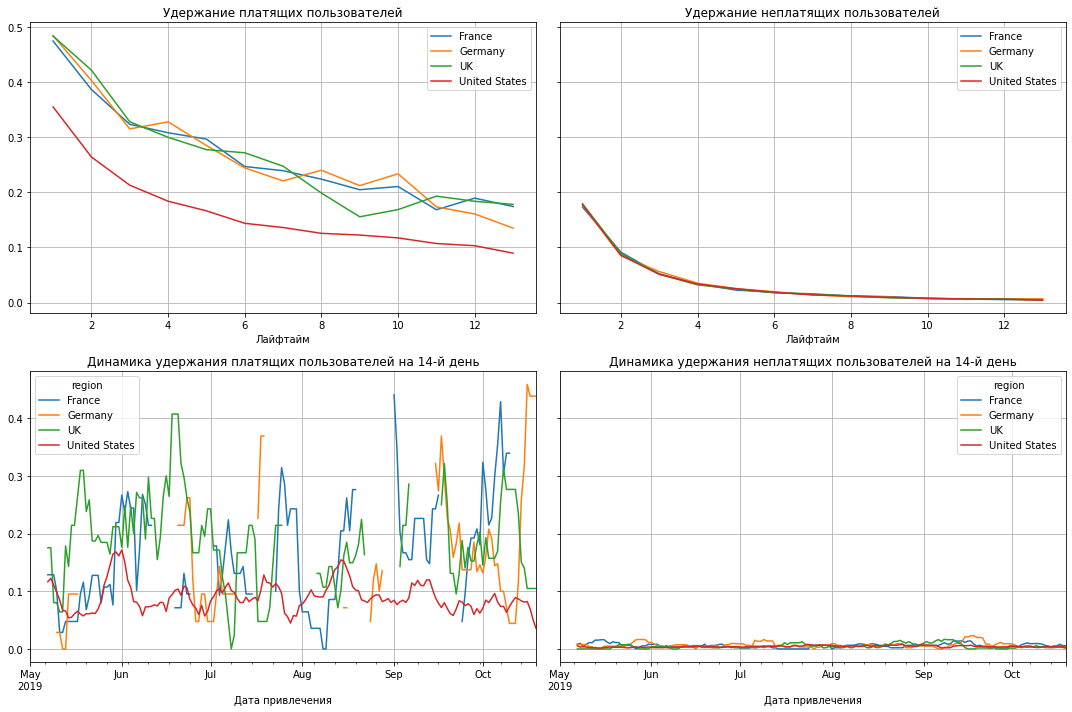

In [115]:
dimensions=['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

___Хуже всего удерживаются пользователи из США, пользователи из остальных стран удерживаются примерно одинаково___

___Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI___

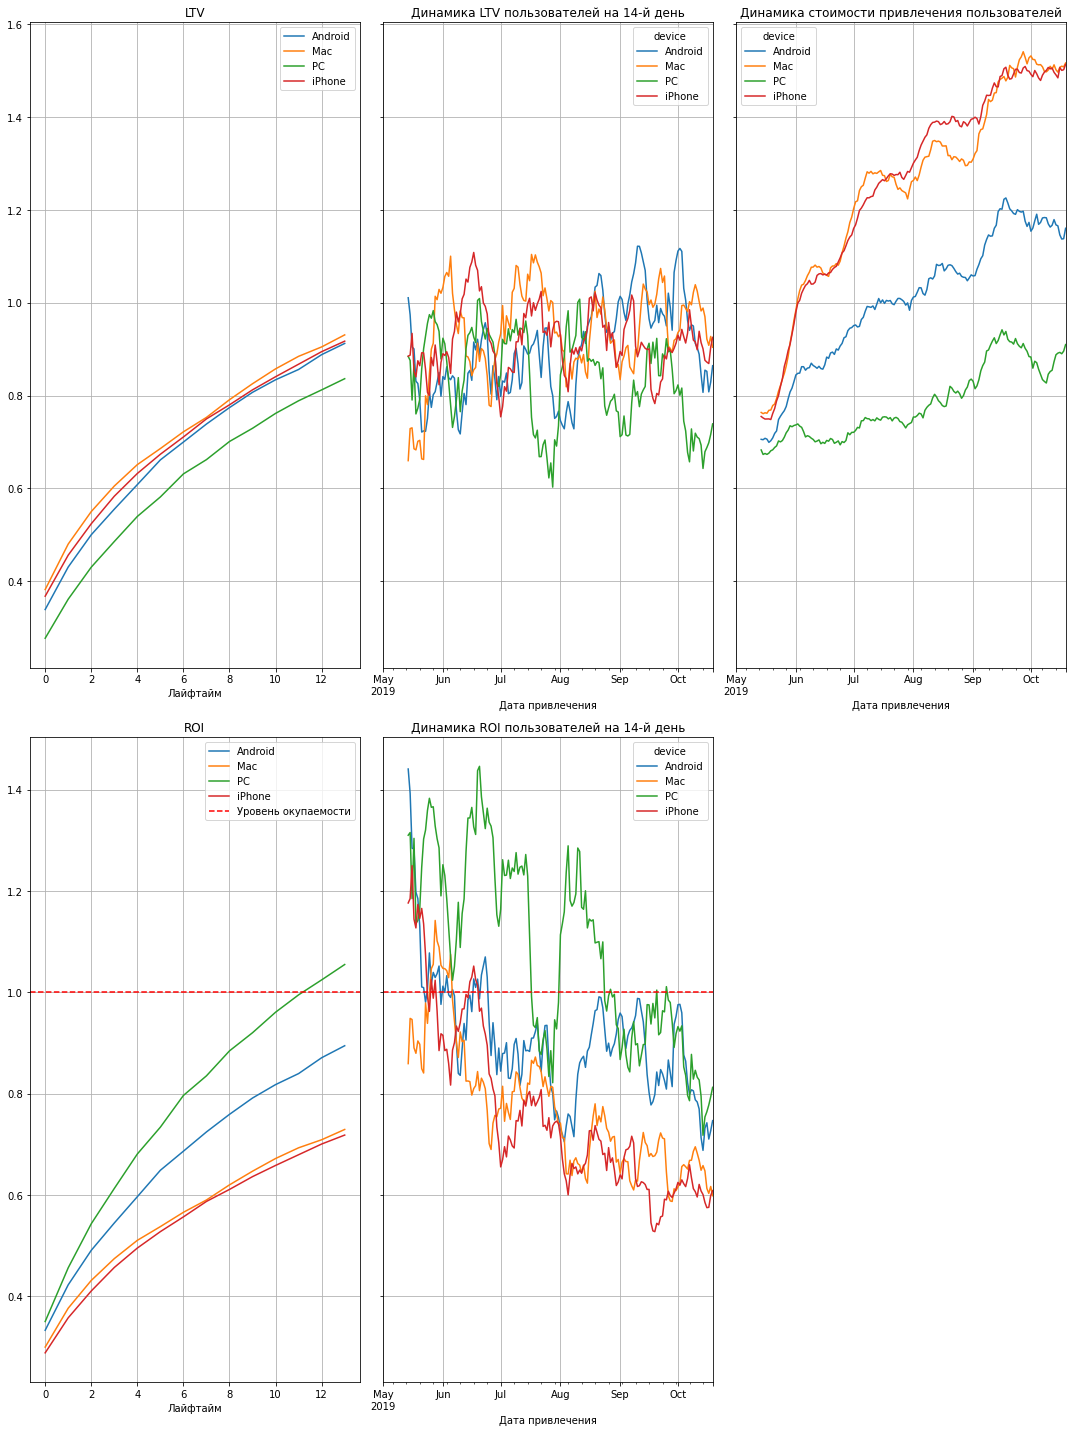

In [116]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

___Проанализировав графики LTV,ROI и CAC с разбивкой по устройствам , видим что :___  
___-Больше всего покупают владельцы IPhone,Mac и Android , меньше остальных владельцы PC___  
___-Стоимость привлечения самая высокая у владельцев Mac и IPhone и она постоянно растет,самая назкая у владельцев PC___  
___-ROI пересекает отметку окупаемости только у владельцев PC . Т.е пользователи остальных устройств не окупаются___  

___Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.___

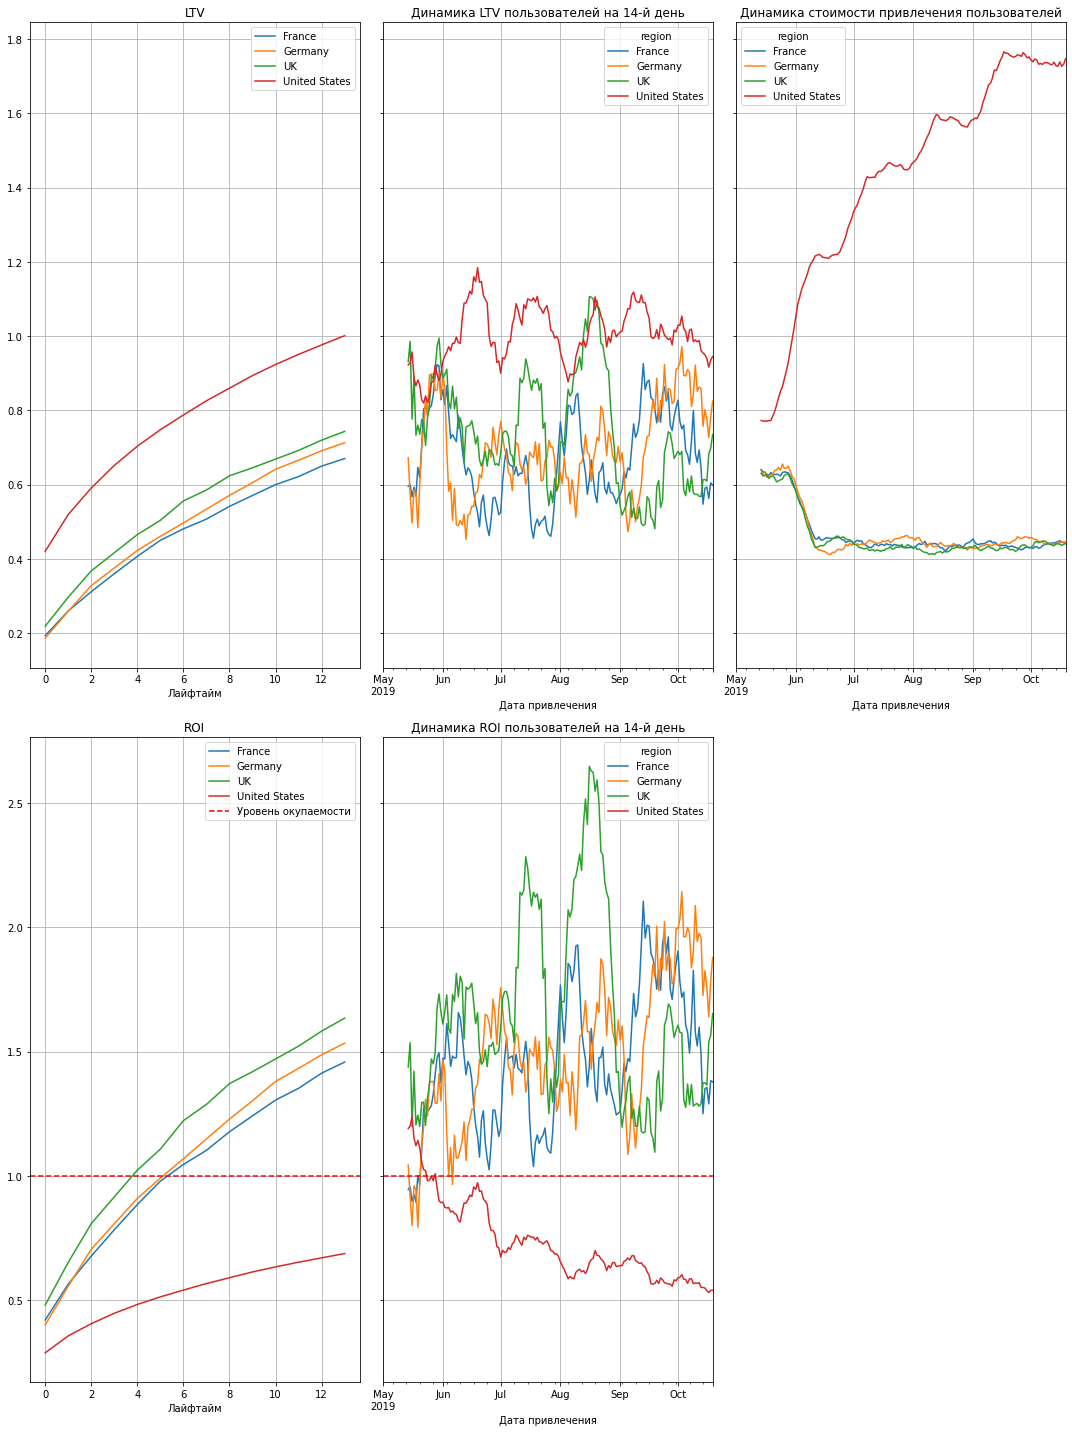

In [117]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

___Судя по графикам , пользователи из США обходятся слишком дорого, и поэтому не окупаются , решила проверить какими устройствами пользуются пользователи из разных стран___

In [118]:
profiles_device_region=profiles.groupby(['region','device']).agg({'user_id':'nunique'})
profiles_device_region.sort_values(by='user_id',ascending=False)

user_id
region        device          
United States iPhone     27548
              Mac        15424
              Android    12436
              PC          6421
UK            PC          4551
France        PC          4384
Germany       PC          3797
France        Android     3313
UK            Android     3243
Germany       Android     2849
UK            iPhone      2274
France        iPhone      2198
Germany       iPhone      1862
France        Mac         1163
UK            Mac         1086
Germany       Mac         1020

___По графикам LTV,ROI и CAC с разбивкой по странам , можно сделать следующие выводы:___  
___-Больше всего покупают пользователи из США,чуть меньше других -из Франции___  
___-Стоимость привлечения пользователей из США намного выше ,чем у пользователей из других стран ,и к тому же постоянно растет. Стоимость привлечения пользователей из Франции ,Германии и Великобритании стабильно невысокая___  
___Быстрее всех окупаются пользователи из Великобритании -на 4 день ,после привлечения , пользователи из Германии и Франции окупаются примерно на 5 день. А пользователи из США-не окупаются совсем___

___Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.___

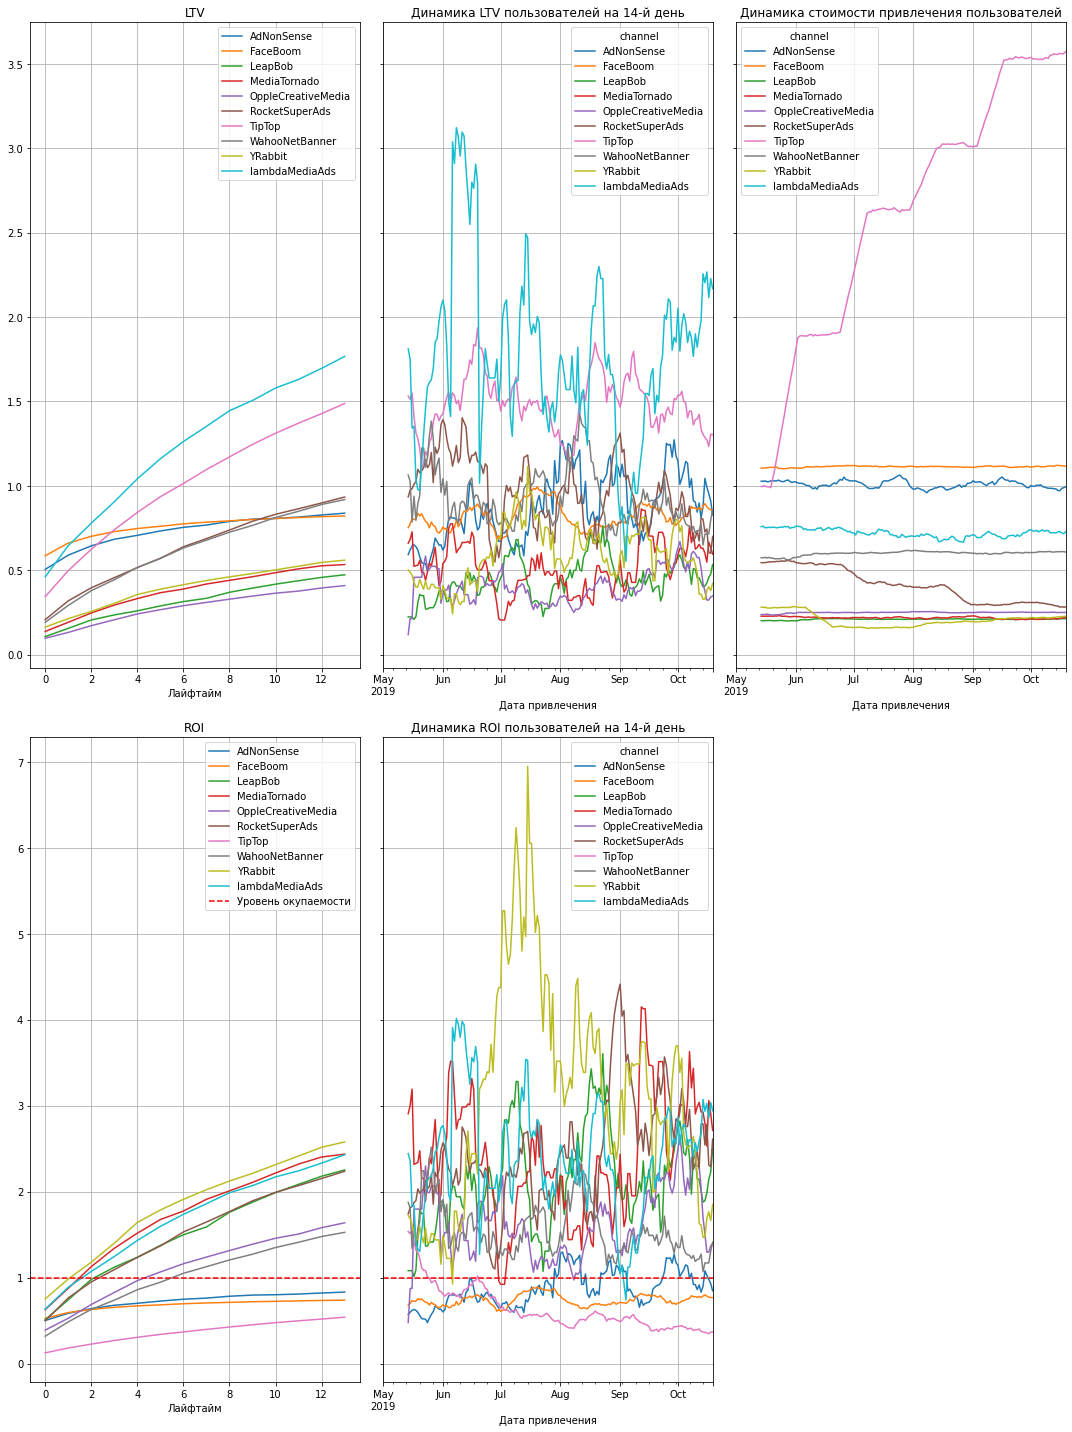

In [119]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

___По графикам LTV,ROI и CAC с разбивкой по каналам привлечения видно:___  
___-по графику LTV -больше всего покупают пользователи пришедшие через канал привлечения LambdaMediaAds и TipTop,меньше всего пользователи с канала привлечения OppleCreativeMedia ,LeapBop___  
___-Стоимость привлечения пользователей через канал TipTop намного вышше остальных каналов и постоянно растет,далее по стоимости FaceBoom и AdNonSense-но они достаточно стабильные-их стоимость не увеличивается со временем.Стоимость привлечения по другим каналам так же стабильная___  
___-Окупаются пользователи со всех каналов привлечения , кроме : FaceBoom,TipTop и AdNonSense. Быстре всех окупаются пользователи с YRabbit, MediaTornado и LambdaMediaAds___  

___Решила так же посмотреть на какие страны приходятся каналы привлечения , как и ожидалось ,самый дорогой канал TipTop -в США___  

In [120]:
profiles_region_channel=profiles.groupby(['region','channel']).agg({'user_id':'nunique'})
profiles_region_channel

user_id
region        channel                    
France        AdNonSense             1366
              LeapBob                2988
              OppleCreativeMedia     2991
              WahooNetBanner         2971
              lambdaMediaAds          742
Germany       AdNonSense             1219
              LeapBob                2519
              OppleCreativeMedia     2562
              WahooNetBanner         2579
              lambdaMediaAds          649
UK            AdNonSense             1295
              LeapBob                3046
              OppleCreativeMedia     3052
              WahooNetBanner         3003
              lambdaMediaAds          758
United States FaceBoom              29144
              MediaTornado           4364
              RocketSuperAds         4448
              TipTop                19561
              YRabbit                4312

In [121]:
profiles=profiles.query('region!="United States"')

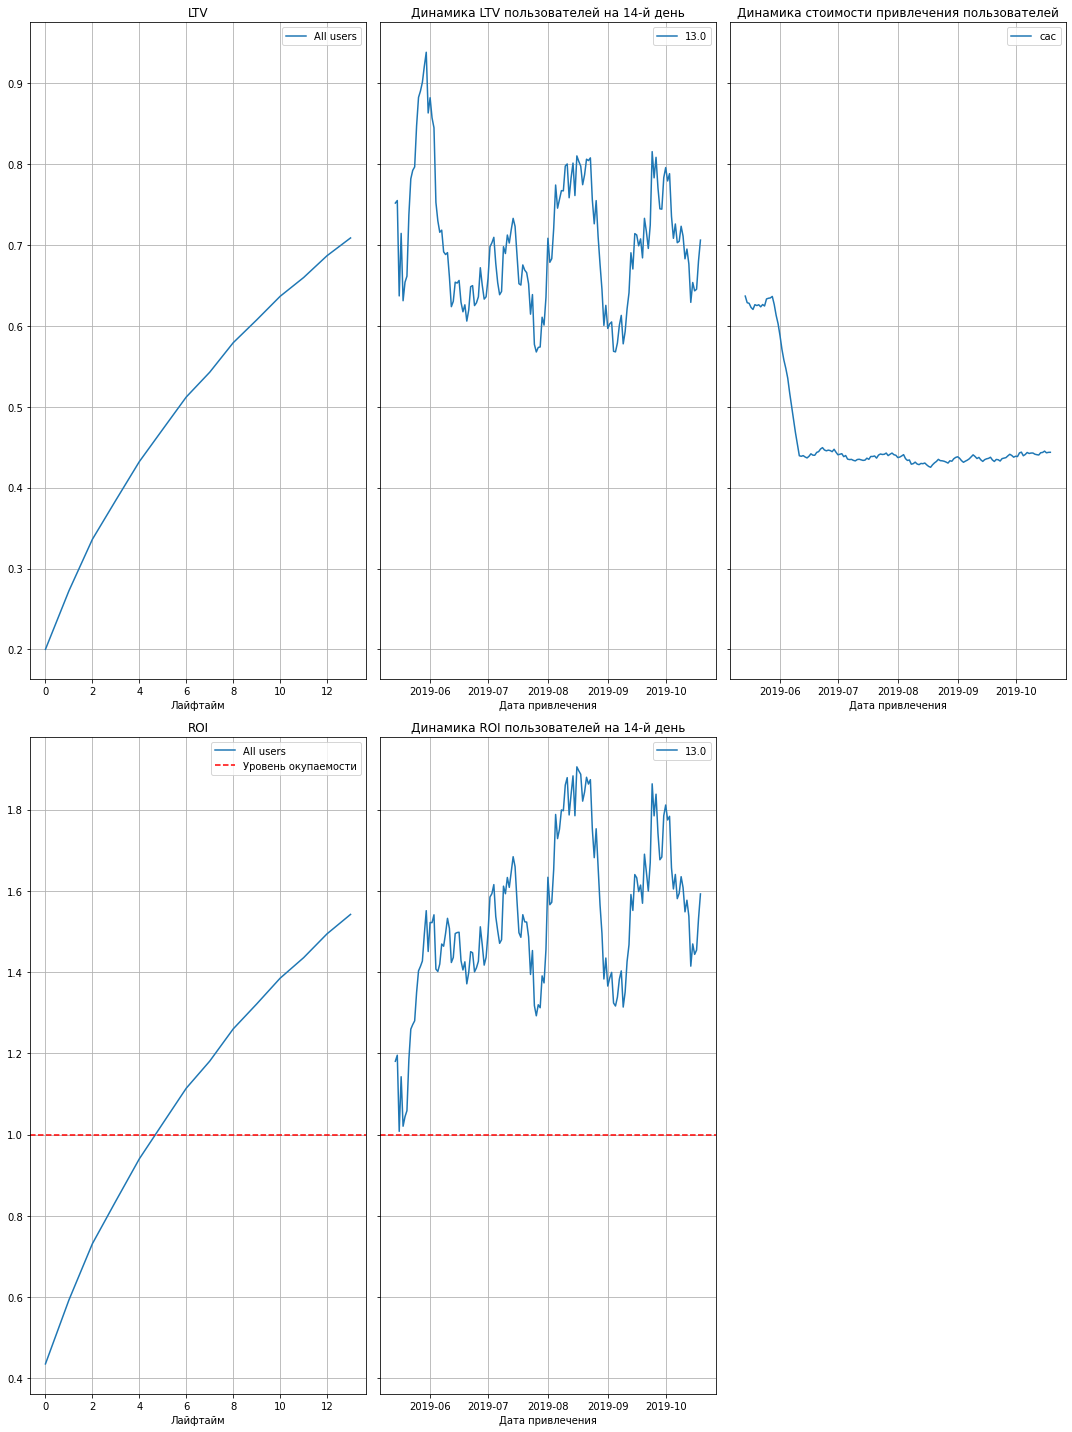

In [122]:
dimensions = []

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

___Если исключить из анализа потльзователей из США,то приложение становится прибыльным. К 14 дню ROI всегда пересекает отметку прибыльности ,  а иногда даже на 5 день после привлечения___  

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.

___После проведения маркетингого исследования ,для выявления причины убыточности развлекательного приложения Procrastinate Pro+ я могу выявить следующие причины неэффективности привлечения пользователей:___  

___-В ходе анализа было выявлено , что большинство пользователей приложения -из США , соответственно они используют устройства Mac или IPhone и приходят через каналы привлечения TipTop и FaceBoom___  

___-в ходе расчета и построения графиков LTV , ROI и CAC с разбивкой по устройсвам ,странам и каналам привлечения было выявлено ,что на канал привлечение пользователей TipTop тратится слишком много денег-и это является причиной неокупаемости этих пользователей.А следовательно, т.к. доля пользователей пришедших в приложение через TipTop одна из самых больших,после FaceBoom(которые так же не окупаются ),убыточность этого канала влияет и на общий показатель. Прибыль от остальных пользователей не покрывает убытки от пользователей ,пришедших через канал TipTop___  

___-С хорошей стороны показал себя источник привлечения LambdaMediaAds.Несмотря на то что , уникальных пользоваелей через него привлеклось не много (2149 чел),но доля платящих достаточно высокая -10,47%, и судя по тому что LTV пользователей ,пришедших через этот канал -самый высокий ,т.е пользователи что-то покупают не один раз и являются "качественными"___  

___Рекомендации для отдела маркетинга возможно сформулировать следующим образом :___  

___-Обратить внимание на расходы на канал привлечения TipTop-попытаться договориться о более низкой стоимости привлечения или отказаться от этого канала . Т.к на него тратится почти половина всех потраченных на рекламу средств и эти пользователи совсем не окупаются___  

___-В США можно обратить внимание на канал привлечения RocketSuperAds-привлечение 1 пользователя обходтится в 41 цент (в отличии от TipTop -2,7дол) и доля платящих пользователей достаточно высокая -7,91% и эти пользователи окупаются___  

___-В остальных странах стоит обратить внимание на канал привлечения LambdaMediaAds -через него приходят самые качественные пользователи и стоимость привлечения тоже приемлемая -около 72 центов___  